In [1]:
import numpy as np
import networkx as nx
import gudhi as gd
from gudhi.persistence_graphical_tools import plot_persistence_barcode, plot_persistence_diagram

# diag = st.persistence()
# plot_persistence_barcode(diag)
import matplotlib.pyplot as plt


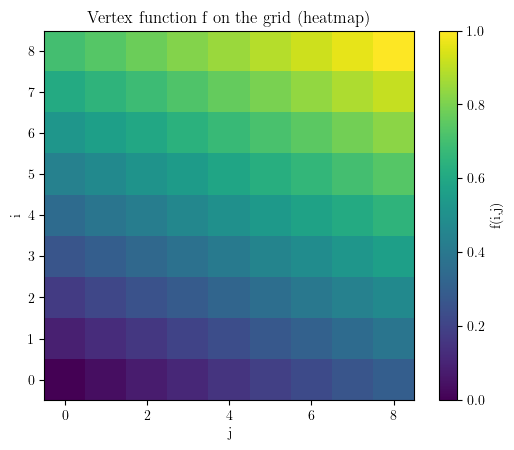

In [8]:
# Larger graph with many cycles: grid graph
m, n = 9, 9
G = nx.grid_2d_graph(m, n)  # nodes are (i, j)

# Relabel nodes to integers for GUDHI SimplexTree
node_list = list(G.nodes())
node_to_int = {v: i for i, v in enumerate(node_list)}
G_int = nx.relabel_nodes(G, node_to_int)

# Vertex function f: gradient + noise (sublevel sets mimic a flooding process)

# Create a reproducible random number generator.
# Using a fixed seed (7) means you will get the same "noise" every run.
rng = np.random.default_rng(7)

# Allocate an array f where f[idx] will store the scalar value for vertex idx.
# G_int uses integer node labels, so f is indexed by those integers.
f = np.zeros(G_int.number_of_nodes(), dtype=float)

# node_to_int maps grid coordinates (i, j) -> integer node id idx.
# i ranges 0..m-1, j ranges 0..n-1 on the grid.
for (i, j), idx in node_to_int.items():

    # 1) Build a smooth "height" (a planar gradient) across the grid:
    #    i/(m-1) and j/(n-1) normalize i and j into [0, 1].
    #
    #    0.7*(i/(m-1)) + 0.3*(j/(n-1)) is a weighted gradient:
    #    - 70% variation comes from the i-direction
    #    - 30% variation comes from the j-direction
    #
    #    So as i increases, f tends to increase more strongly than as j increases.
    base_gradient = 0.7*(i/(m-1)) + 0.3*(j/(n-1))

    # 2) Add random perturbation so vertices do not enter the filtration
    #    in perfectly aligned "fronts".
    #
    #    rng.normal() ~ N(0, 1). Multiplying by 0.15 sets the noise scale.
    #    Larger -> more scrambled birth times; smaller -> more smooth structure.
    noise = 0.0 * rng.normal()

    # Store the final vertex value.
    f[idx] = base_gradient + noise

# Normalize f to [0, 1] for nicer numeric scale / plots.
# This does NOT change the ordering of vertex values (a monotone transform),
# so it does not change the filtration's topology

# Build an (m, n) array from your f using node_to_int: (i,j) -> idx
f_grid = np.zeros((m, n), dtype=float)
for (i, j), idx in node_to_int.items():
    f_grid[i, j] = f[idx]

# If you didn't already normalize, normalize for clean color scale
f_grid = (f_grid - f_grid.min()) / (f_grid.max() - f_grid.min() + 1e-12)

# 2D heatmap
plt.figure()
plt.imshow(f_grid, origin="lower")
plt.colorbar(label="f(i,j)")
plt.title("Vertex function f on the grid (heatmap)")
plt.xlabel("j")
plt.ylabel("i")
plt.show()



In [9]:
def simplex_tree_lower_star_graph(G_int, f):
    st = gd.SimplexTree()
    # vertices
    for v in G_int.nodes():
        st.insert([v], filtration=float(f[v]))
    # edges
    for u, v in G_int.edges():
        st.insert([u, v], filtration=float(max(f[u], f[v])))

    st.initialize_filtration()
    return st

st = simplex_tree_lower_star_graph(G_int, f)
print("simplices:", st.num_simplices(), "dimension:", st.dimension())


simplices: 225 dimension: 1


/var/folders/pb/wqsj3_6x3sb1k1xhpfyk924w0000gn/T/ipykernel_84651/3180501118.py:10: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  st.initialize_filtration()


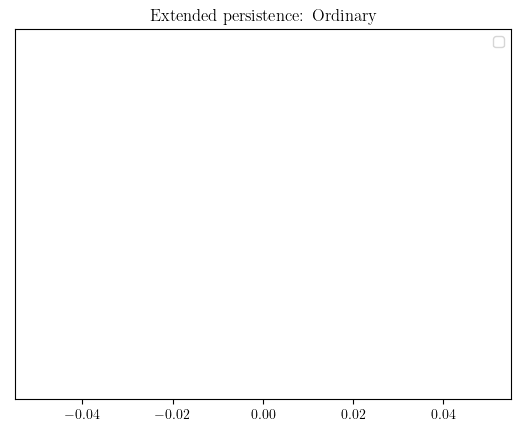

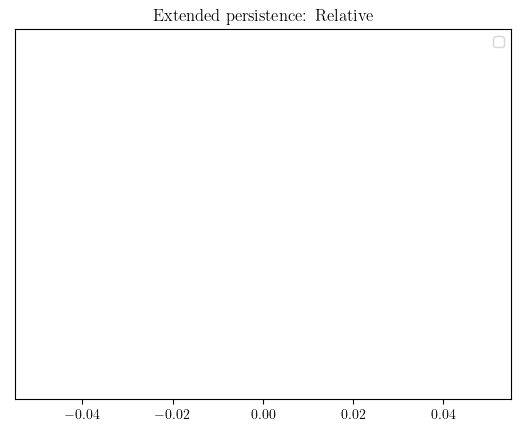

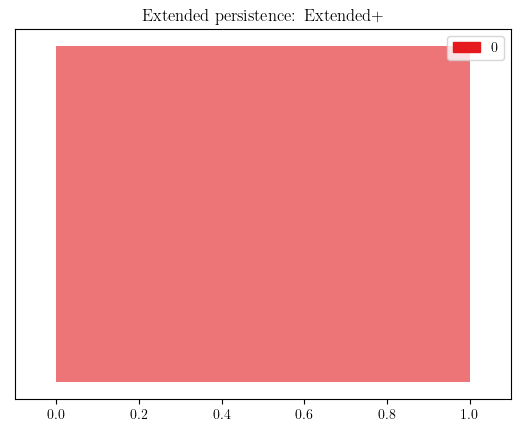

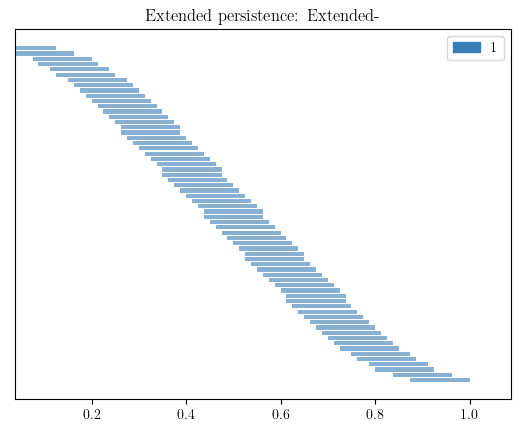

In [10]:
# Required by GUDHI before calling extended_persistence()
st.extend_filtration()

ord_diag, rel_diag, extp_diag, extm_diag = st.extended_persistence()

for title, dgm in [
    ("Extended persistence: Ordinary", ord_diag),
    ("Extended persistence: Relative", rel_diag),
    ("Extended persistence: Extended+", extp_diag),
    ("Extended persistence: Extended-", extm_diag),
]:
    gd.plot_persistence_barcode(dgm)
    plt.title(title)
    plt.show()


In [ ]:
import numpy as np
from gudhi.representations import PersistenceImage

def _safe_diag(dgm):
    """Ensure diagram is a (k,2) float array; allow empty diagrams."""
    if dgm is None:
        return np.empty((0, 2), dtype=float)
    dgm = np.asarray(dgm, dtype=float)
    if dgm.size == 0:
        return np.empty((0, 2), dtype=float)
    return dgm.reshape(-1, 2)

def vectorize_extended_persistence(
    ord_dgm, rel_dgm, extp_dgm, extm_dgm,
    dims=(0, 1),
    resolution=(20, 20),
    bandwidth=0.05,
    im_range=None,   # e.g., [0, 1, 0, 1] in birth-persistence coords if you pre-transform
    weight=None
):
    """
    Returns a fixed-size vector by concatenating Persistence Images for:
    (ordinary, relative, ext+, ext-) × (H0, H1 by default).
    """
    # PI expects diagrams as birth-death; internally it uses a weighted Gaussian image. :contentReference[oaicite:8]{index=8}
    pi = PersistenceImage(
        bandwidth=bandwidth,
        resolution=list(resolution),
        im_range=im_range if im_range is not None else [np.nan]*4,
        weight=(weight if weight is not None else (lambda x: 1.0))
    )

    # Each "part" is a list of (dim, (k,2) array) tuples; we split by dim manually.
    parts = [ord_dgm, rel_dgm, extp_dgm, extm_dgm]
    feat_chunks = []

    for part in parts:
        # part is a list like [(dim, (b,d)), ...] depending on how you stored it,
        # OR it may already be a diagram list from GUDHI plotting functions.
        # Here we assume it's in GUDHI extended_persistence format: list of (dim,(birth,death)).
        for d in dims:
            dgm = np.array([pair for (dim, pair) in part if dim == d], dtype=float)
            dgm = _safe_diag(dgm)

            # fit_transform expects a list of diagrams; output shape is (n_diagrams, pixels). :contentReference[oaicite:9]{index=9}
            vec = pi.fit_transform([dgm])[0]
            feat_chunks.append(vec)

    return np.concatenate(feat_chunks, axis=0)




In [11]:
# Example usage after you computed:
st.extend_filtration()
ord_dgm, rel_dgm, extp_dgm, extm_dgm = st.extended_persistence()
v = vectorize_extended_persistence(ord_dgm, rel_dgm, extp_dgm, extm_dgm)
print(v.shape)  # fixed every time

(3200,)


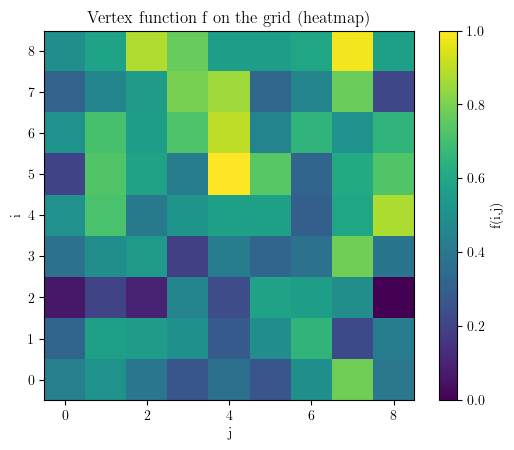

In [6]:
# Larger graph with many cycles: grid graph
m, n = 9, 9
G = nx.grid_2d_graph(m, n)  # nodes are (i, j)

# Relabel nodes to integers for GUDHI SimplexTree
node_list = list(G.nodes())
node_to_int = {v: i for i, v in enumerate(node_list)}
G_int = nx.relabel_nodes(G, node_to_int)

# Vertex function f: gradient + noise (sublevel sets mimic a flooding process)

# Create a reproducible random number generator.
# Using a fixed seed (7) means you will get the same "noise" every run.
rng = np.random.default_rng(7)

# Allocate an array f where f[idx] will store the scalar value for vertex idx.
# G_int uses integer node labels, so f is indexed by those integers.
f = np.zeros(G_int.number_of_nodes(), dtype=float)

# node_to_int maps grid coordinates (i, j) -> integer node id idx.
# i ranges 0..m-1, j ranges 0..n-1 on the grid.
for (i, j), idx in node_to_int.items():

    # 1) Build a smooth "height" (a planar gradient) across the grid:
    #    i/(m-1) and j/(n-1) normalize i and j into [0, 1].
    #
    #    0.7*(i/(m-1)) + 0.3*(j/(n-1)) is a weighted gradient:
    #    - 70% variation comes from the i-direction
    #    - 30% variation comes from the j-direction
    #
    #    So as i increases, f tends to increase more strongly than as j increases.
    base_gradient = 0.7*(i/(m-1)) + 0.3*(j/(n-1))

    # 2) Add random perturbation so vertices do not enter the filtration
    #    in perfectly aligned "fronts".
    #
    #    rng.normal() ~ N(0, 1). Multiplying by 0.15 sets the noise scale.
    #    Larger -> more scrambled birth times; smaller -> more smooth structure.
    noise = 0.95 * rng.normal()

    # Store the final vertex value.
    f[idx] = base_gradient + noise

# Normalize f to [0, 1] for nicer numeric scale / plots.
# This does NOT change the ordering of vertex values (a monotone transform),
# so it does not change the filtration's topology

# Build an (m, n) array from your f using node_to_int: (i,j) -> idx
f_grid = np.zeros((m, n), dtype=float)
for (i, j), idx in node_to_int.items():
    f_grid[i, j] = f[idx]

# If you didn't already normalize, normalize for clean color scale
f_grid = (f_grid - f_grid.min()) / (f_grid.max() - f_grid.min() + 1e-12)

# 2D heatmap
plt.figure()
plt.imshow(f_grid, origin="lower")
plt.colorbar(label="f(i,j)")
plt.title("Vertex function f on the grid (heatmap)")
plt.xlabel("j")
plt.ylabel("i")
plt.show()


simplices: 225 dimension: 1


/var/folders/pb/wqsj3_6x3sb1k1xhpfyk924w0000gn/T/ipykernel_84651/3180501118.py:10: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  st.initialize_filtration()


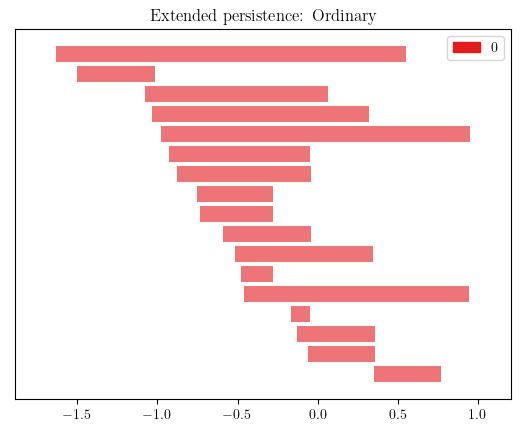

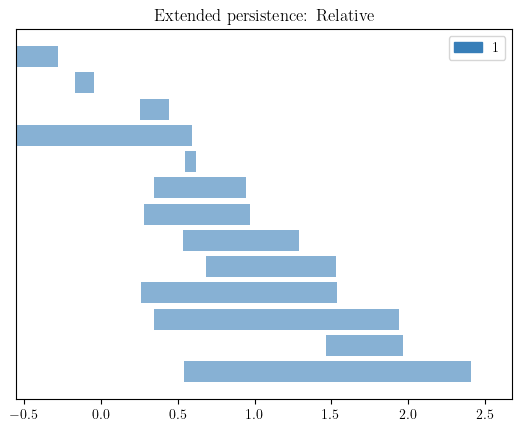

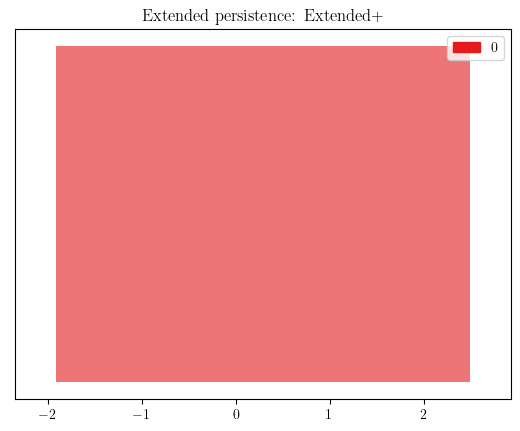

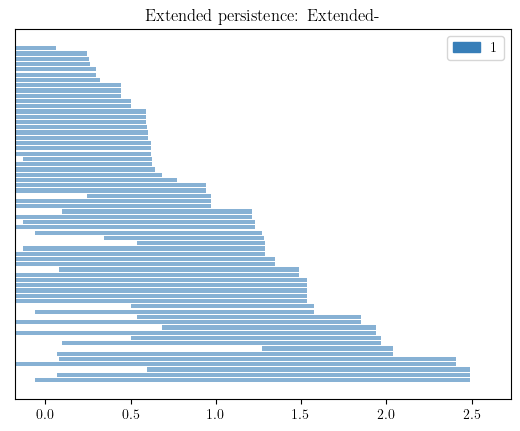

In [7]:
st = simplex_tree_lower_star_graph(G_int, f)
print("simplices:", st.num_simplices(), "dimension:", st.dimension())

# Required by GUDHI before calling extended_persistence()
st.extend_filtration()

ord_diag, rel_diag, extp_diag, extm_diag = st.extended_persistence()

for title, dgm in [
    ("Extended persistence: Ordinary", ord_diag),
    ("Extended persistence: Relative", rel_diag),
    ("Extended persistence: Extended+", extp_diag),
    ("Extended persistence: Extended-", extm_diag),
]:
    gd.plot_persistence_barcode(dgm)
    plt.title(title)
    plt.show()
